In [1]:
from __future__ import division
from importlib import reload
from modules import * 
import pickle
import csv
fig_savedir = '../data/figures/'
from scipy.stats import entropy


#CURRENTLY 
# - FREEZE WEIGHTS == TRUE
# - in maze.reset() around_reward defaults True
#don't forget to turn it off before running trials without preloaded weights
def normalize_output(img):
    img = img - img.min()
    img = img / img.max()
    return img

In [2]:
reload(eu)
grid_params = {
    'y_height':     15, 
    'x_width':      15,
    'walls':        False,
    'rho':          0,
    'maze_type':    'none',
    'barheight':    14,
    'port_shift':   'none',
    'step_penaliz': -0.01,
    'rwd_loc':      [(2,2)]
}

#make environment

maze = eu.gridworld(grid_params)
maze.rwd_loc


[(2, 2)]

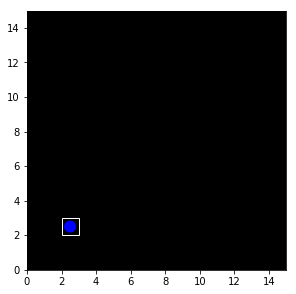

In [32]:
agent_params = {
        'load_model':   True,
        'load_dir':     '../data/outputs/gridworld/openfield_poke{}{}.pt'.format(grid_params['x_width'],grid_params['y_height']),
        'rwd_placement': 'training_loc',
        
        'state_type':   'conv',
        'lin_dims':     500,
        'rfsize':       4,
        'stride':       1,
        'action_dims':  len(maze.actionlist),
        'temperature':  1,
    
        'batch_size':   1,
        'gamma':        0.98, #discount factor
        'eta':          5e-4,
        
        'use_EC':       True,
        'cachelim':     300, # memory limit should be ~75% of #actions x #states
        'EC':           {},
        'mem_temp':     0.3
        
    }
run_dict = ac.reset_agt(maze, agent_params, rwd_placement=[(2,2)])


if agent_params['use_EC']:
    #agent_params['cachelim'] = int(0.5*np.prod(maze.grid.shape))
    agent_params['EC'] = ec.ep_mem(run_dict['agent'],agent_params['cachelim'])

gp.plot_env(run_dict['environment'])

In [33]:
#time_running = 0
#tot_reward = []

In [52]:
training = False
new_test = True
mem_test = True
### TRAINING
if training:
    time_running = 0
    tot_reward = []
    rwd = [(2,2)]
    rec_mem = False
    use_ec = False
    freeze_weights = False
    num_trials = 5000
else:
    if new_test:
        time_running = 3000
        tot_reward = tot_reward[0:time_running]
        num_trials = 1000
    if mem_test:
        rec_mem = True
        use_ec = True
        freeze_weights = False
        num_trials = 500
    rwd = [(12,12)]

reload(expt)
maze = eu.gridworld(grid_params, around_reward =True)
run_dict = ac.reset_agt(maze, 
                        agent_params, 
                        freeze_weights=freeze_weights, rwd_placement = rwd)
run_dict['NUM_TRIALS'] = num_trials
print(maze.rwd_loc)
expt.run(run_dict,full=False, rec_mem=rec_mem, use_EC=use_ec, plots =False) ## by default runs truncated trials with MF only
time_running += run_dict['NUM_TRIALS']
tot_reward += run_dict['total_reward']
#ac.torch.save(run_dict['agent'],agent_params['load_dir'])

[(12, 12)]
0 2.3690962386006458
0.0
[15:23:14]  Trial 1 TotRew = -2.99999999999998 (0.380s)
[15:32:13]  Trial 101 TotRew = -2.99999999999998 (538.253s)
[15:41:35]  Trial 201 TotRew = -2.99999999999998 (562.742s)
[15:49:50]  Trial 301 TotRew = -2.99999999999998 (494.855s)
[15:59:47]  Trial 401 TotRew = -2.99999999999998 (596.817s)
[16:09:23]  Trial 500 TotRew = -0.5700000000000012 (576.216s)


0.6993987975951904


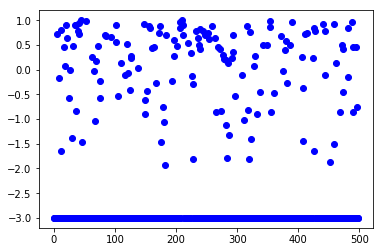

In [67]:
#ac.torch.save(run_dict['agent'],agent_params['load_dir'])
tr = tot_reward[3000:-1]
plt.plot(tr, 'bo')
prop_fail = len([i for i in tr if i < -2.9])/len(tr)
print(prop_fail)
#pickle.dump(agent_params, open('../data/outputs/gridworld/1515_test/agent_params_MFonly.p', "wb"))

In [76]:
#plt.imshow(np.vstack(run_dict['pp']).T, aspect='auto', vmin=0, vmax=1,cmap=plt.cm.Spectral_r)
#plt.yticks(ticks=np.arange(6), labels = maze.actionlist)
#plt.vlines(x=len(training_policy_1212), ymin=-0.5,ymax=5.5, linestyles=':')
#plt.colorbar()
a = np.array([0.,1. ,0.,0.,0. ,0.])
b = np.array([0.,0. ,0.,0.,0. ,1.])
c = np.array([0.,0.5,0.,0.,0.5,0.])
d = ac.softmax(np.array([1,1,1,1,1,1]))
print(entropy(a,d))

2.6804328739937056


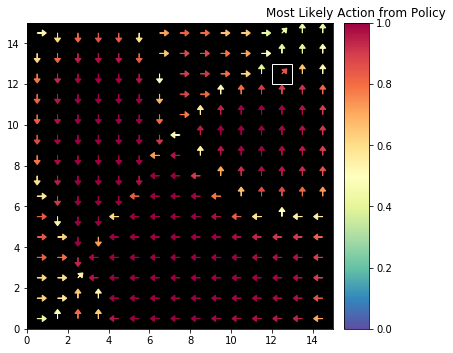

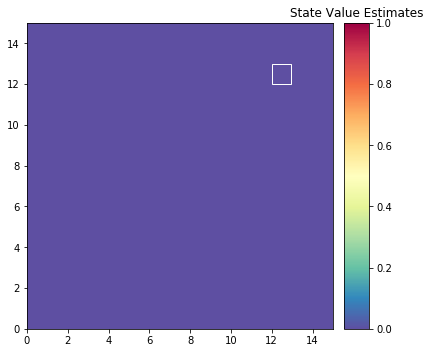

In [54]:
policy_loss = run_dict['total_loss'][0]
value_loss = run_dict['total_loss'][1]
#tot_reward = run_dict['total_reward']
#trial_length = run_dict['trial_length']

#plt.plot(tot_reward)
#plt.show()

vv, pp = ac.snapshot(agent=run_dict['agent'], maze =run_dict['environment'])

gp.plot_polmap(run_dict['environment'], pp, threshold=0.22)
gp.plot_valmap(run_dict['environment'], vv, v_range =[0,1])

In [ ]:
for i in range(10):
    gp.plot_valmap(maze, run_dict['pp'][i])

In [ ]:
### TESTING 

#reload(gp)
#reload(expt)
num_samples = 1
kld_samples = []
for sample in range(num_samples):
    print(sample)
    maze = eu.gridworld(grid_params, around_reward = False)
    run_dict = ac.reset_agt(maze, 
                            agent_params, 
                            freeze_weights=True)
    run_dict['NUM_TRIALS'] = 100

    expt.run(run_dict,full=False, rec_mem=True, use_EC=False) ## by default runs truncated trials with MF only
    
    ec_policies = ac.mem_snapshot(maze, 
                       agent_params['EC'], 
                       trial_timestamp = 50, 
                       decay           = ec.calc_env(halfmax = 20), 
                       mem_temp        = 0.3)
    a = gp.plot_polmap(maze, ec_policies)
    __, mf_pols = ac.snapshot(agent=run_dict['agent'], maze =run_dict['environment'])
    mf_policies = np.vstack(mf_pols)
    
    kld = np.zeros(ec_policies.shape)
    for i in range(ec_policies.shape[0]):
        for j in range(ec_policies.shape[1]):
            if sum([e for e in ec_policies[i][j]]) == 0.0:
                kld[i][j] = np.nan
            else:
                mf_pol = ac.softmax([m for m in mf_policies[i][j]])
                ec_pol = ac.softmax([e for e in ec_policies[i][j]])
                kld[i][j] = entropy(ec_pol,mf_pol)
    kld_samples.append(kld)

In [ ]:
# Average kld over 100 samples of 50 trials
gp.plot_valmap(run_dict['environment'], np.average(kld_samples, axis=0), v_range = [0,0.12], title=f"Average KLD over {len(kld_samples)} runs", save=False)

In [ ]:
import math 
#kld_samples = pickle.load( open( "../data/kld_whole_field.p", "rb" ) )
rows = 20
cols = 20
average = np.zeros((rows,cols))
num_samples = np.zeros((rows, cols))
for i in range(len(kld_samples)):
    for j in range(rows):
        for k in range(cols):
            if not math.isnan(kld_samples[i][j][k]):
                average[j][k] += kld_samples[i][j][k]
                num_samples[j][k] += 1

new_avg = np.zeros_like(average)
for i in range(rows):
    for j in range(cols):
        if num_samples[i][j] == 0.0:
            new_avg[i][j] = np.nan
        else:
            new_avg[i][j] = average[i][j]/num_samples[i][j]


#pickle.dump(kld_samples, open('../data/kld_whole_field.p', "wb"))

In [ ]:
alphas = num_samples/100

vmin, vmax = [0,0.12]
fig = plt.figure(figsize=(7,5))
ax1 = fig.add_axes([0, 0, 0.85, 0.85])
axc = fig.add_axes([0.75, 0, 0.05, 0.85])
cmap = plt.cm.Spectral_r
cNorm = colors.Normalize(vmin=vmin, vmax=vmax)
cb1 = colorbar.ColorbarBase(axc, cmap=cmap, norm=cNorm)
imshow_kwargs = {
    'vmax': vmax,
    'vmin': vmin,
    'cmap': cmap,
}
transparency = colors.Normalize(vmin, vmax, clip=True)(new_avg)
transparency = cmap(transparency)
transparency[:,:,-1] = alphas+0.5
#print(new_avg.shape, (num_samples/100).shape)
ax1.imshow(transparency, **imshow_kwargs)
ax1.add_patch(plt.Rectangle((maze.rwd_loc[0][0]-0.5, maze.rwd_loc[0][1]-0.5), width=1, height=1, linewidth=1.1, ec='white', fill=False))
ax1.invert_yaxis()
#plt.savefig('../data/randstartKLD_100_samples.png', format='png',bbox_inches='tight')

In [ ]:
print(pp[0][0])

In [ ]:
ac.torch.save(run_dict['agent'],agent_params['load_dir'])

In [ ]:
# get weights from conv layer and normalize them for visualization
weights = run_dict['agent'].hidden[0].weight.data
weights = normalize_output(weights)

n_filters, ix = 3, 1
for i in range(n_filters):
    # get filter:
    f = weights[i,:,:,:]
    for j in range(3):
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(f[j,:,:], cmap ='gray')
        ix+=1
plt.show()

In [ ]:

state = torch.Tensor(maze.observation)
print(maze.cur_state)
policy_, value_, lin_act_ = run_dict['agent'](state)
conv = run_dict['agent'].conv.data[0].numpy()
print(conv.shape)
for i in range(3):
    plt.imshow(conv[i,:,:],cmap='gray')
    plt.show()

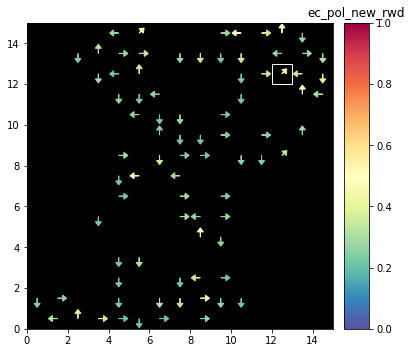

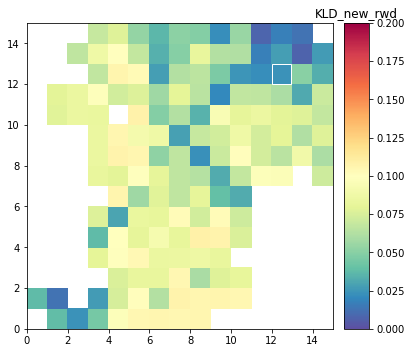

In [55]:
reload(ac)
abcd, efgh = ac.mem_snapshot(maze, 
                       agent_params['EC'], 
                       trial_timestamp = 500, 
                       decay           = ec.calc_env(halfmax = 20), 
                       mem_temp        = 0.3,
                            get_vals=True)#agent_params['mem_temp'])
gp.plot_polmap(maze, abcd,save=True, threshold = 0.22, title='ec_pol_new_rwd')

# KL Divergence
ec_policies = abcd
mf_policies = np.vstack(pp) 

kld = np.zeros(ec_policies.shape)
for i in range(ec_policies.shape[0]):
    for j in range(ec_policies.shape[1]):
        if sum([e for e in ec_policies[i][j]]) == 0.0:
            kld[i][j] = np.nan
      
        else:
            mf_pol = ac.softmax([m for m in mf_policies[i][j]])
            ec_pol = ac.softmax([e for e in ec_policies[i][j]])
            kld[i][j] = entropy(ec_pol,mf_pol)
gp.plot_valmap(maze, kld, save=True, title='KLD_new_rwd', v_range=[0,.2])


In [ ]:
#abcd
ec_closeup = []
labels = [] 
radius = 3
r,c = maze.rwd_loc[0][1], maze.rwd_loc[0][0]
for i in range(radius*2):
    ec_closeup.append([])
    labels.append([])
    for j in range(radius*2):
        ec_closeup[i].append(abcd[r-radius+i][c-radius+j])
        labels[i].append((r-radius+i, c-radius+j))
ec_closeup = np.asarray(ec_closeup)

print(type(labels[0][0][0]))

In [ ]:
num_rows = ec_closeup.shape[0]
num_cols = ec_closeup.shape[1]

fig, ax = plt.subplots(num_rows,num_cols, sharex=True, sharey=True)

ax[0,0].set_ylim([0,1])
ax[0,0].set_yticks([])
ax[0,0].set_xticks([])
for k in range(num_rows):
    i = num_rows-k-1
    for j in range(num_cols):
        ec_data = list(ec_closeup[k][j])
        ax[i,j].bar(np.arange(6), ec_data)
        if labels[k][j] == (maze.rwd_loc[0][1], maze.rwd_loc[0][0]):
            ax[i,j].text(s='*', x=2,y=0.5,fontsize=16,color='r')
        ax[i,j].text(s=maze.actionlist[np.argmin(ec_data)], x=0.0,y=0.7,fontsize=8)
        ax[i,j].text(s=maze.actionlist[np.argmax(ec_data)], x=4,y=0.7,fontsize=8)

In [ ]:
num_rows = ec_closeup.shape[0]
num_cols = ec_closeup.shape[1]

fig, ax = plt.subplots(num_rows,num_cols, sharex=True, sharey=True)

ax[0,0].set_ylim([0,1])
ax[0,0].set_yticks([])
ax[0,0].set_xticks([])
for k in range(num_rows):
    i = k
    print(k, i)
    for j in range(num_cols):
        ec_data = list(ec_closeup[i][j])
        ax[i,j].bar(np.arange(6), ec_data)
        if labels[i][j] == (maze.rwd_loc[0][1], maze.rwd_loc[0][0]):
            ax[i,j].text(s='*', x=2,y=0.5,fontsize=16,color='r')
        ax[i,j].text(s=maze.actionlist[np.argmin(ec_data)], x=0.0,y=0.7,fontsize=8)
        ax[i,j].text(s=maze.actionlist[np.argmax(ec_data)], x=4,y=0.7,fontsize=8)

In [ ]:
# print state action values
data_frame = []
for i in range(6): # num actions
    data_frame.append(np.zeros((maze.y, maze.x)))
    for j in range(maze.x): # width
        for k in range(maze.y): #height
            data_frame[i][k,j] = efgh[k,j][i]
    gp.plot_valmap(maze,data_frame[i], title =f"State Action Value Estimate for = {maze.actionlist[i]}", v_range = [-1,1])

In [ ]:
#tot_reward += run_dict['total_reward']
plt.plot(tot_reward,'bo')
plt.show()

In [ ]:
val_tens = [np.zeros((10,10)) for i in range(6)]
print(len(val_tens))
for index, x in np.ndenumerate(efgh):
    for i in range(6):
        val_tens[i][index]= x[i]

In [ ]:
acts = run_dict['environment'].actionlist
reload(gp)
for i in range(6):
    gp.plot_valmap(run_dict['environment'],val_tens[i], p_range = [val_tens[i].min(), val_tens[0].max()], title='action='+acts[i])

In [ ]:
#set_aside = abcd
### this is for plotting the biggest change in the policy after a single reward is received
'''
hootenany = np.zeros_like(abcd)
for index, x in np.ndenumerate(abcd):
    change = np.asarray(list(abcd[index]) - np.asarray(list(set_aside[index])))
    hootenany[index] = tuple(change)

gp.plot_polmap(maze, hootenany)
'''

In [ ]:
policy_loss = run_dict['total_loss'][0]
value_loss = run_dict['total_loss'][1]
tot_reward = run_dict['total_reward']
trial_length = run_dict['trial_length']

In [ ]:
max_ysteps = int(grid_params['y_height']/2)
max_xsteps = int(grid_params['x_width']/2)

reward_threshold = 1+ grid_params['step_penaliz']*(max_xsteps + max_ysteps)
print(reward_threshold)

fig, ax = plt.subplots(2,1, sharex=True)
ax[0].plot(gp.running_mean(tot_reward,30))
ax[0].plot(tot_reward, 'b', alpha = 0.2)
ax[0].axhline(reward_threshold)
#plt.plot(trial_length)
ax[1].plot(policy_loss)
plt.show()
plt.close()

rwd_mean = gp.running_mean(tot_reward,30)
plt.figure(1)
plt.plot(rwd_mean)
plt.plot(tot_reward, 'b', alpha = 0.2)
plt.axhline(reward_threshold)
plt.savefig('rdtest.svg', format='svg')

get_sd =np.where(rwd_mean > reward_threshold)[0]
clipped_pol_loss = policy_loss[get_sd:-1]
print(np.std(clipped_pol_loss))

#pick = [tot_reward, policy_loss, value_loss, trial_length]
#pickle.dump(pick, open("pickles/initial_training.p", "wb"))

In [ ]:
reload(gp)


In [ ]:
ttt = ac.mem_snapshot(run_dict['environment'], agent_params['EC'], trial_timestamp=1, decay=100)
gp.plot_polmap(run_dict['environment'],ttt)

In [ ]:
key_ = 0 
for k, v in agent_params['EC'].cache_list.items():
    if v[2] == (10,10):
        key_ = k
        print(agent_params['EC'].cache_list[key_][0])

plt.figure()
plt.bar(np.arange(6), agent_params['EC'].recall_mem(key_, 26))
plt.ylim([0,1])

In [ ]:
fig,ax = plt.subplots(2,1, sharex=True)
ax[0].plot(policy_loss)
ax[0].axvline(x = run_dict['NUM_TRIALS'],color='k', linestyle=':', alpha=0.5)
ax[0].set_ylabel('Policy Loss')
ax[1].plot(value_loss)
ax[1].axvline(x = run_dict['NUM_TRIALS'],color='k', linestyle=':', alpha=0.5)
ax[1].set_ylabel('Value Loss')

#ax[0].arrow(2000, max(policy_loss), 0, -600, head_width=50, head_length=100, fc='k', ec='k')
#ax[1].arrow(2000, max(value_loss), 0, -600, head_width=50, head_length=100, fc='k', ec='k')

#plt.savefig('../data/figures/loss_after_trunc_training.svg', format='svg')
plt.show()
plt.close()

In [ ]:
x = -1
print(value_loss[x])
print(policy_loss[x])

In [ ]:
vv, pp = ac.snapshot(agent=run_dict['agent'], maze =run_dict['environment'])
reload(gp)
gp.plot_polmap(run_dict['environment'], pp)
gp.plot_valmap(run_dict['environment'], vv, p_range=[0,1.5])

In [ ]:
def test_pvals(p, **kwargs):
    envelope = kwargs.get('envelope', 50)
    mfc      = kwargs.get('conf_score', 1)
    return mfc*np.round(1 / np.cosh(p / envelope), 8)

In [ ]:

a = np.linspace(1,200, 100)#np.sort(np.random.randint(1,100,10))
b = 10*np.arange(10)+5
for i in b:
    a_p = test_pvals(a, envelope=i)
    plt.plot(a, a_p, '-', label=f'{i}')
plt.legend(loc=0)
#ax[1].plot(a_p)


In [ ]:
EC = agent_params['EC']

In [ ]:
import time
meas_time = time.time()
x = np.asarray(list(agent_params['EC'].cache_list.keys()))
#x = np.asarray([*agent_params['EC'].cache_list.keys()])
print(time.time() - meas_time)

In [ ]:
reload(ec)
test_case = x[0]+ 0.3*(np.random.randn(500))
key, index, sim = EC.cosine_sim(test_case)
print(key[0:10], index, sim)
EC.recall_mem(key, timestep=1)


In [ ]:
import seaborn as sns


In [ ]:
def make_pvals(p, envelope):
    return np.round(1 / np.cosh(p / envelope), 8)
## try to plot relationship of envelope and half max x value 
bunchadots = np.linspace(0, 1000, 10000)
envs = np.arange(50, step = 2)+1

cp = sns.color_palette(n_colors=len(envs))

tracking = []
for ind, i in enumerate(envs):
    sech = make_pvals(bunchadots, envelope=i)
    plt.plot(bunchadots,sech, color = cp[ind])
    xhalfmax = bunchadots[np.where(sech<0.5)[0][0]]
    plt.plot(xhalfmax,0.5, color = cp[ind], marker = 'o')
    tracking.append((i, xhalfmax))
plt.xlim([0,100])

In [ ]:
bunchadots = np.linspace(0, 10, 1000)
sech = make_pvals(bunchadots, envelope = 0.78967)
plt.plot(bunchadots, sech)
plt.xlim([0,5])
plt.axhline(0.5, color='r')
plt.axvline(1.04, color = 'r')

plt.axvline(3.12, color = 'g')
plt.axhline(0.04, color = 'g')

In [ ]:
a = np.zeros(5)
b = 0.5
for i in range(len(a)):
    a[i] = b*(b**i)
print(a)

In [ ]:
ac.torch.save(run_dict['agent'],agent_params['load_dir'])